# 🧭 QAOA para o Problema do Caixeiro Viajante (TSP)

## Implementação Didática Alinhada com a Formulação Teórica

Este notebook implementa o TSP usando QAOA seguindo a formulação matemática:

1. **Variáveis de decisão**: $x_{i,t} \in \{0,1\}$
2. **Formulação QUBO**: $H_{QUBO} = H_{dist} + H_{p1} + H_{p2}$
3. **Mapeamento quântico**: $x_{i,t} \rightarrow \frac{I - \hat{Z}_{i,t}}{2}$
4. **QAOA**: Operadores $U_C(\gamma)$ e $U_M(\beta)$

---
## 📦 Importar Bibliotecas

In [1]:
# Importar bibliotecas importantes
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from qiskit_aer import AerSimulator
from qiskit import transpile
from scipy.optimize import minimize
from itertools import permutations
import matplotlib.pyplot as plt

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


---
## 📊 Definição dos Parâmetros do Problema

### Matriz de Distâncias $D$

A matriz $D$ contém as distâncias $d_{ij}$ entre cada par de cidades.

### Variáveis de Decisão $x_{i,t}$

$$x_{i,t} = \begin{cases} 1 & \text{se a cidade } i \text{ é visitada no passo } t \\ 0 & \text{caso contrário} \end{cases}$$

Para $n$ cidades, temos $n^2$ variáveis binárias, ou seja, **$n^2$ qubits**.

In [2]:
# Definição dos parâmetros do problema TSP
# Diferente do MaxCut que usa arestas, o TSP usa uma matriz de distâncias

# Matriz de distâncias para 3 cidades (inicializando variável)
D = np.array([
    [0, 10, 15],
    [10, 0, 20],
    [15, 20, 0]
], dtype=float)

num_cidades = len(D)
num_qubits = num_cidades ** 2  # n² qubits para TSP

print(f"📍 Número de cidades (n): {num_cidades}")
print(f"⚛️  Número de qubits (n²): {num_qubits}")
print(f"\n📊 Matriz de distâncias D:")
print(D.astype(int))

📍 Número de cidades (n): 3
⚛️  Número de qubits (n²): 9

📊 Matriz de distâncias D:
[[ 0 10 15]
 [10  0 20]
 [15 20  0]]


In [3]:
# Mapeamento (cidade, tempo) → índice do qubit
# x_{i,t} corresponde ao qubit de índice (i * n + t)

def qubit_index(cidade, tempo, n):
    """
    Mapeia a variável x_{i,t} para o índice do qubit.
    
    Seguindo a notação do texto teórico:
    x_{i,t} → qubit[i * n + t]
    """
    return cidade * n + tempo


# Visualização do mapeamento
print("🔢 Mapeamento de variáveis x_{i,t} para qubits:")
print("="*50)
print(f"{'Variável':<12} {'Qubit':<8} {'Significado'}")
print("-"*50)
for i in range(num_cidades):
    for t in range(num_cidades):
        q = qubit_index(i, t, num_cidades)
        print(f"x_{{{i},{t}}}        q[{q}]     Cidade {i} no tempo {t}")

🔢 Mapeamento de variáveis x_{i,t} para qubits:
Variável     Qubit    Significado
--------------------------------------------------
x_{0,0}        q[0]     Cidade 0 no tempo 0
x_{0,1}        q[1]     Cidade 0 no tempo 1
x_{0,2}        q[2]     Cidade 0 no tempo 2
x_{1,0}        q[3]     Cidade 1 no tempo 0
x_{1,1}        q[4]     Cidade 1 no tempo 1
x_{1,2}        q[5]     Cidade 1 no tempo 2
x_{2,0}        q[6]     Cidade 2 no tempo 0
x_{2,1}        q[7]     Cidade 2 no tempo 1
x_{2,2}        q[8]     Cidade 2 no tempo 2


---
## 📐 Construção do Hamiltoniano de Custo

### Formulação QUBO

O Hamiltoniano QUBO combina o custo das distâncias com as penalidades:

$$H_{QUBO} = \underbrace{\sum_{i,j=0}^{n-1} \sum_{t=0}^{n-1} d_{ij} \, x_{i,t} \, x_{j,(t+1) \mod n}}_{H_{dist}} + \underbrace{A \sum_{i=0}^{n-1} \left( \sum_{t=0}^{n-1} x_{i,t} - 1 \right)^2}_{H_{p1}} + \underbrace{A \sum_{t=0}^{n-1} \left( \sum_{i=0}^{n-1} x_{i,t} - 1 \right)^2}_{H_{p2}}$$

Onde:
- $H_{dist}$: Custo total da rota
- $H_{p1}$: Penalidade - cada cidade visitada exatamente uma vez
- $H_{p2}$: Penalidade - cada tempo tem exatamente uma cidade
- $A$: Fator de penalidade (deve ser $> \max(d_{ij}) \cdot n$)

### Mapeamento para Operadores de Pauli

$$x_{i,t} \longrightarrow \hat{n}_{i,t} = \frac{I - \hat{Z}_{i,t}}{2}$$

Isso resulta em termos $Z_i$ (campo local) e $Z_i Z_j$ (interação).

In [4]:
# Fator de penalidade A
# Conforme o texto: "A deve ser superior a qualquer distância possível no grafo"
A = np.max(D) * num_cidades + 1

print(f"⚖️  Fator de penalidade A = {A}")
print(f"   (max(D) = {np.max(D)}, garantindo A > qualquer rota válida)")

⚖️  Fator de penalidade A = 61.0
   (max(D) = 20.0, garantindo A > qualquer rota válida)


In [5]:
def construir_hamiltoniano_tsp(D, A):
    """
    Constrói os coeficientes do Hamiltoniano de custo para o TSP.
    
    Seguindo a formulação teórica, o Hamiltoniano quântico é:
    Ĥ_C = Σ h_i Z_i + Σ J_ij Z_i Z_j
    
    Derivado de H_QUBO usando a substituição x = (1-Z)/2
    
    Retorna:
    --------
    h : dict
        Coeficientes dos termos Z_i (campo local)
    J : dict  
        Coeficientes dos termos Z_i Z_j (interação)
    """
    n = len(D)
    h = {}  # Termos Z_i
    J = {}  # Termos Z_i Z_j
    
    # Inicializa coeficientes
    for q in range(n * n):
        h[q] = 0.0
    
    # =========================================
    # H_dist: Termo de distância
    # Σ_{i,j,t} d_ij * x_{i,t} * x_{j,(t+1) mod n}
    # =========================================
    # Usando x_a * x_b = (1-Z_a)(1-Z_b)/4:
    # = (1 - Z_a - Z_b + Z_a Z_b) / 4
    # Coeficientes: constante +1/4, Z_a: -1/4, Z_b: -1/4, Z_a Z_b: +1/4
    
    for i in range(n):
        for j in range(n):
            if i != j:
                d_ij = D[i, j]
                for t in range(n):
                    t_next = (t + 1) % n
                    q_a = qubit_index(i, t, n)      # x_{i,t}
                    q_b = qubit_index(j, t_next, n) # x_{j,t+1}
                    
                    # Coeficientes (multiplicados por d_ij)
                    h[q_a] -= d_ij / 4
                    h[q_b] -= d_ij / 4
                    
                    # Termo ZZ
                    key = (min(q_a, q_b), max(q_a, q_b))
                    J[key] = J.get(key, 0) + d_ij / 4
    
    # =========================================
    # H_p1: Cada cidade visitada exatamente uma vez
    # A * Σ_i (Σ_t x_{i,t} - 1)²
    # =========================================
    # Expandindo (Σx - 1)² = Σx² + 2Σ_{t<t'}x_t x_{t'} - 2Σx + 1
    # Como x² = x: = Σx + 2Σ_{t<t'}x_t x_{t'} - 2Σx + 1 = -Σx + 2Σ_{t<t'}x_t x_{t'} + 1
    
    for i in range(n):
        for t in range(n):
            q = qubit_index(i, t, n)
            # Termo -A*x = -A*(1-Z)/2 → contribui com +A/2 para Z
            h[q] += A / 2
            
            # Termos cruzados 2A * x_{i,t} * x_{i,t'}
            for t2 in range(t + 1, n):
                q2 = qubit_index(i, t2, n)
                # 2A * x * x' usando expansão
                h[q] -= A / 2
                h[q2] -= A / 2
                key = (min(q, q2), max(q, q2))
                J[key] = J.get(key, 0) + A / 2
    
    # =========================================
    # H_p2: Cada tempo tem exatamente uma cidade
    # A * Σ_t (Σ_i x_{i,t} - 1)²
    # =========================================
    
    for t in range(n):
        for i in range(n):
            q = qubit_index(i, t, n)
            h[q] += A / 2
            
            for i2 in range(i + 1, n):
                q2 = qubit_index(i2, t, n)
                h[q] -= A / 2
                h[q2] -= A / 2
                key = (min(q, q2), max(q, q2))
                J[key] = J.get(key, 0) + A / 2
    
    return h, J


# Construir Hamiltoniano
h, J = construir_hamiltoniano_tsp(D, A)

print(f"\n📐 Hamiltoniano de Custo Ĥ_C construído:")
print(f"   Termos Z_i (campo local): {len([v for v in h.values() if abs(v) > 1e-10])}")
print(f"   Termos Z_i Z_j (interação): {len(J)}")


📐 Hamiltoniano de Custo Ĥ_C construído:
   Termos Z_i (campo local): 9
   Termos Z_i Z_j (interação): 36


In [6]:
# Exibir alguns termos do Hamiltoniano
print("\n📜 Primeiros termos do Hamiltoniano Ĥ_C:")
print("="*50)
print("\nTermos Z_i (campo local):")
for q, coef in list(h.items())[:5]:
    if abs(coef) > 1e-10:
        i, t = q // num_cidades, q % num_cidades
        print(f"   {coef:+.2f} · Z_{{{i},{t}}}")

print("\nTermos Z_i Z_j (interação):")
for (q1, q2), coef in list(J.items())[:5]:
    if abs(coef) > 1e-10:
        i1, t1 = q1 // num_cidades, q1 % num_cidades
        i2, t2 = q2 // num_cidades, q2 % num_cidades
        print(f"   {coef:+.2f} · Z_{{{i1},{t1}}} Z_{{{i2},{t2}}}")


📜 Primeiros termos do Hamiltoniano Ĥ_C:

Termos Z_i (campo local):
   -73.50 · Z_{0,0}
   -73.50 · Z_{0,1}
   -73.50 · Z_{0,2}
   -76.00 · Z_{1,0}
   -76.00 · Z_{1,1}

Termos Z_i Z_j (interação):
   +2.50 · Z_{0,0} Z_{1,1}
   +2.50 · Z_{0,1} Z_{1,2}
   +2.50 · Z_{0,2} Z_{1,0}
   +3.75 · Z_{0,0} Z_{2,1}
   +3.75 · Z_{0,1} Z_{2,2}


---
## 🔄 Camada (Layer) do QAOA

### Estrutura do Circuito QAOA

Cada camada do QAOA consiste em dois operadores:

**1. Operador de Custo (Phase Operator):**
$$U_C(\gamma) = e^{-i \gamma \hat{H}_C}$$

**2. Operador de Mistura (Mixer):**
$$U_M(\beta) = e^{-i \beta \hat{H}_M}, \quad \text{com} \quad \hat{H}_M = \sum_{k=1}^{n^2} \hat{X}_k$$

### Implementação no Circuito

- Termo $e^{-i\gamma h_k Z_k}$ → Porta **RZ(2γh_k)** no qubit k
- Termo $e^{-i\gamma J_{ij} Z_i Z_j}$ → **CNOT(i,j) · RZ(2γJ_ij) · CNOT(i,j)**
- Termo $e^{-i\beta X_k}$ → Porta **RX(2β)** no qubit k

In [7]:
def qaoa_layer(qc, h, J, gamma, beta):
    """
    Implementa uma camada do QAOA para o TSP.
    
    Esta função é análoga à qaoa_layer do MaxCut, mas com diferenças:
    - MaxCut: apenas termos ZZ para arestas
    - TSP: termos Z (campo local) + termos ZZ (interações)
    
    Conforme o texto teórico:
    U_C(γ) = exp(-iγ Ĥ_C) onde Ĥ_C = Σ h_i Z_i + Σ J_ij Z_i Z_j
    U_M(β) = exp(-iβ Ĥ_M) onde Ĥ_M = Σ X_k
    
    Parâmetros:
    -----------
    qc : QuantumCircuit
        Circuito quântico
    h : dict
        Coeficientes dos termos Z_i
    J : dict
        Coeficientes dos termos Z_i Z_j
    gamma : float
        Parâmetro γ do operador de custo
    beta : float
        Parâmetro β do operador mixer
    """
    # =========================================
    # OPERADOR DE CUSTO U_C(γ)
    # =========================================
    
    # Termos Z_i: exp(-iγ h_i Z_i) = RZ(2γ h_i)
    for qubit, coef in h.items():
        if abs(coef) > 1e-10:
            qc.rz(2 * gamma * coef, qubit)
    
    # Termos Z_i Z_j: exp(-iγ J_ij Z_i Z_j)
    # Implementação: CNOT(i,j) · RZ(2γJ_ij,j) · CNOT(i,j)
    for (q_i, q_j), coef in J.items():
        if abs(coef) > 1e-10:
            qc.cx(q_i, q_j)
            qc.rz(2 * gamma * coef, q_j)
            qc.cx(q_i, q_j)
    
    # =========================================
    # OPERADOR MIXER U_M(β)
    # Ĥ_M = Σ X_k (igual ao MaxCut)
    # =========================================
    for q in range(qc.num_qubits):
        qc.rx(2 * beta, q)


print("✅ Função qaoa_layer definida")
print("\n📝 Estrutura da camada:")
print("   1. RZ(2γh_i) para cada qubit i (termos de campo local)")
print("   2. CNOT-RZ-CNOT para cada par (i,j) (termos de interação)")
print("   3. RX(2β) para cada qubit (mixer)")

✅ Função qaoa_layer definida

📝 Estrutura da camada:
   1. RZ(2γh_i) para cada qubit i (termos de campo local)
   2. CNOT-RZ-CNOT para cada par (i,j) (termos de interação)
   3. RX(2β) para cada qubit (mixer)


---
## 🔌 Circuito Completo do QAOA

O circuito QAOA completo é construído:

1. **Estado inicial**: Superposição uniforme $|s\rangle = |+\rangle^{\otimes n^2}$
2. **Camadas QAOA**: Aplicação alternada de $U_C(\gamma_l)$ e $U_M(\beta_l)$ para $l = 1, ..., p$

$$|\psi(\vec{\gamma}, \vec{\beta})\rangle = \prod_{l=1}^{p} U_M(\beta_l) U_C(\gamma_l) |+\rangle^{\otimes n^2}$$

In [8]:
def qaoa_circuit(h, J, num_qubits, gammas, betas):
    """
    Constrói o circuito completo do QAOA para o TSP.
    
    Conforme o texto teórico:
    |ψ(γ,β)⟩ = Π_{l=1}^{p} U_M(β_l) U_C(γ_l) |+⟩^{⊗n²}
    
    Parâmetros:
    -----------
    h : dict
        Coeficientes Z_i do Hamiltoniano
    J : dict
        Coeficientes Z_i Z_j do Hamiltoniano
    num_qubits : int
        Número de qubits (n²)
    gammas : list
        Parâmetros γ para cada camada
    betas : list
        Parâmetros β para cada camada
    
    Retorna:
    --------
    qc : QuantumCircuit
        Circuito QAOA completo
    """
    qc = QuantumCircuit(num_qubits)
    
    # Estado inicial: |+⟩^{⊗n²}
    # Aplicação de Hadamard em todos os qubits
    qc.h(range(num_qubits))
    
    # Camadas QAOA
    for gamma, beta in zip(gammas, betas):
        qaoa_layer(qc, h, J, gamma, beta)
    
    return qc


print("✅ Função qaoa_circuit definida")

✅ Função qaoa_circuit definida



📊 Circuito QAOA para TSP (n=3, p=1):
   Qubits: 9
   Profundidade: 39
   Portas: {'cx': 72, 'rz': 45, 'h': 9, 'rx': 9}


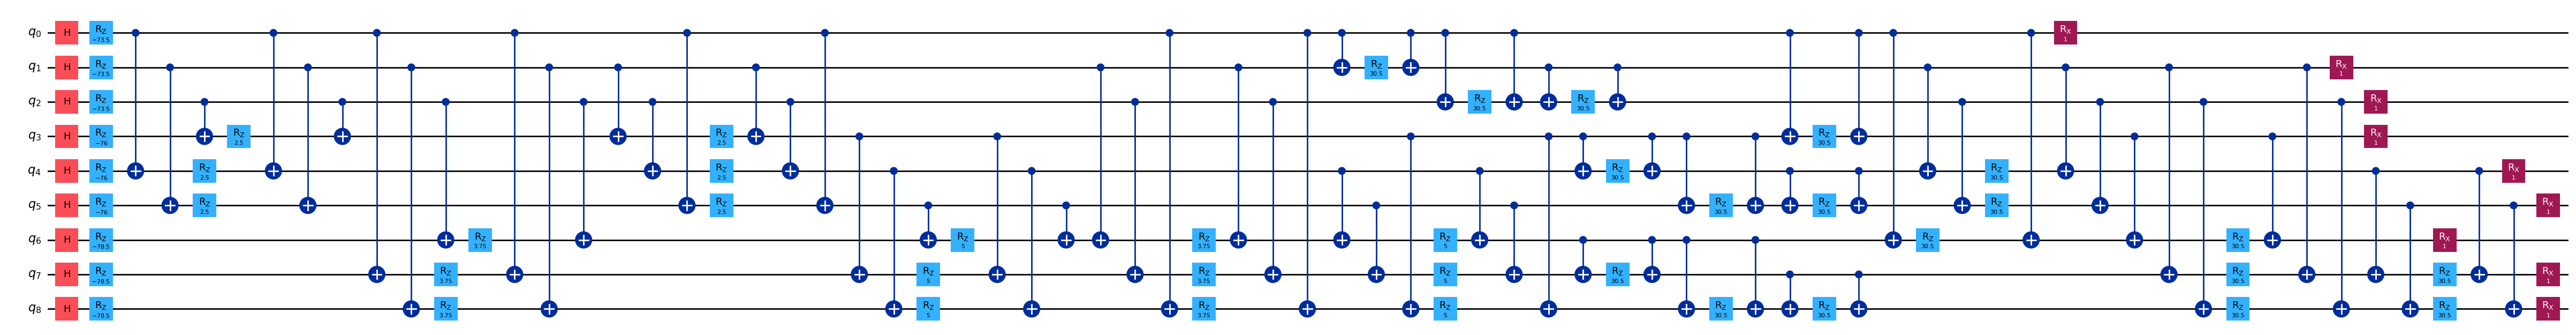

In [9]:
# Visualizar circuito QAOA para p=1 camada
qc_exemplo = qaoa_circuit(h, J, num_qubits, gammas=[0.5], betas=[0.5])

print(f"\n📊 Circuito QAOA para TSP (n={num_cidades}, p=1):")
print(f"   Qubits: {qc_exemplo.num_qubits}")
print(f"   Profundidade: {qc_exemplo.depth()}")
print(f"   Portas: {dict(qc_exemplo.count_ops())}")

# Desenhar circuito
qc_exemplo.draw('mpl', fold=80)

---
## 💰 Função Custo do TSP

### Diferença do MaxCut

No MaxCut, qualquer bitstring é uma solução válida. No TSP, precisamos:

1. **Verificar validade**: A bitstring representa uma rota válida?
2. **Calcular custo**: Se válida, qual o custo da rota?

### Decodificação

Uma bitstring de $n^2$ bits codifica a matriz $x_{i,t}$:
- `bitstring[i*n + t] = 1` significa cidade $i$ visitada no tempo $t$

In [10]:
def decodificar_bitstring(bitstring, n):
    """
    Decodifica uma bitstring em uma rota TSP.
    
    Verifica as restrições do texto teórico:
    1. Σ_t x_{i,t} = 1 para todo i (cada cidade visitada uma vez)
    2. Σ_i x_{i,t} = 1 para todo t (cada tempo tem uma cidade)
    
    Retorna:
    --------
    rota : tuple ou None
        Sequência de cidades ou None se inválida
    valida : bool
        True se satisfaz as restrições
    """
    # Reconstrói matriz x[cidade][tempo]
    x = np.zeros((n, n), dtype=int)
    for idx, bit in enumerate(bitstring):
        cidade = idx // n
        tempo = idx % n
        x[cidade, tempo] = int(bit)
    
    # Verifica restrição 1: Σ_t x_{i,t} = 1
    for i in range(n):
        if np.sum(x[i, :]) != 1:
            return None, False
    
    # Verifica restrição 2: Σ_i x_{i,t} = 1
    for t in range(n):
        if np.sum(x[:, t]) != 1:
            return None, False
    
    # Extrai rota
    rota = []
    for t in range(n):
        for i in range(n):
            if x[i, t] == 1:
                rota.append(i)
                break
    
    rota.append(rota[0])  # Fecha o ciclo
    return tuple(rota), True


print("✅ Função decodificar_bitstring definida")

✅ Função decodificar_bitstring definida


In [11]:
def tsp_cost(bitstring, D):
    """
    Calcula o custo de uma solução TSP.
    
    Implementa a função objetivo do texto teórico:
    C(x) = Σ_{i,j,t} d_ij * x_{i,t} * x_{j,(t+1) mod n}
    
    Retorna:
    --------
    custo : float
        Custo da rota (ou infinito se inválida)
    rota : tuple ou None
        Rota decodificada
    valida : bool
        Se a solução é válida
    """
    n = len(D)
    rota, valida = decodificar_bitstring(bitstring, n)
    
    if not valida:
        return float('inf'), None, False
    
    # Calcula custo da rota
    custo = 0
    for t in range(n):
        i = rota[t]
        j = rota[t + 1]
        custo += D[i, j]
    
    return custo, rota, True


# Demonstração
print("\n🔍 Exemplos de decodificação:")
print("="*50)

# Solução válida: cidade 0→1→2→0
bs_valida = "100010001"  # x_00=1, x_11=1, x_22=1
custo, rota, valida = tsp_cost(bs_valida, D)
print(f"Bitstring: {bs_valida}")
print(f"   Válida: {valida}")
print(f"   Rota: {rota}")
print(f"   Custo: {custo}")

print()

# Solução inválida
bs_invalida = "110000001"
custo, rota, valida = tsp_cost(bs_invalida, D)
print(f"Bitstring: {bs_invalida}")
print(f"   Válida: {valida}")
print(f"   Rota: {rota}")
print(f"   Custo: {custo}")


🔍 Exemplos de decodificação:
Bitstring: 100010001
   Válida: True
   Rota: (0, 1, 2, 0)
   Custo: 45.0

Bitstring: 110000001
   Válida: False
   Rota: None
   Custo: inf


In [12]:
def expected_cost(counts, D):
    """
    Calcula o valor esperado da função custo TSP.
    
    ⟨Ĥ_C⟩ = Σ_x P(x) * C(x)
    
    Para soluções inválidas, usa penalidade alta.
    
    Retorna:
    --------
    exp_cost : float
        Valor esperado do custo
    frac_validas : float
        Fração de soluções válidas medidas
    melhor : tuple
        (melhor_rota, melhor_custo) encontrados
    """
    n = len(D)
    shots = sum(counts.values())
    
    # Penalidade para soluções inválidas
    penalidade = np.max(D) * n * 10
    
    exp_cost = 0
    n_validas = 0
    melhor_custo = float('inf')
    melhor_rota = None
    
    for bitstring, count in counts.items():
        # Qiskit retorna bitstring invertida
        bs = bitstring[::-1]
        
        custo, rota, valida = tsp_cost(bs, D)
        
        if valida:
            n_validas += count
            exp_cost += count * custo
            
            if custo < melhor_custo:
                melhor_custo = custo
                melhor_rota = rota
        else:
            exp_cost += count * penalidade
    
    return exp_cost / shots, n_validas / shots, (melhor_rota, melhor_custo)


print("✅ Função expected_cost definida")

✅ Função expected_cost definida


---
## 🎯 Função Objetivo (Minimização do QAOA)

O ciclo híbrido clássico-quântico:

1. **Quântico**: Prepara $|\psi(\gamma, \beta)\rangle$ e mede
2. **Clássico**: Calcula $\langle \psi | \hat{H}_C | \psi \rangle$ e ajusta parâmetros

O otimizador clássico minimiza o valor esperado para encontrar os parâmetros ótimos.

In [13]:
# Simulador
sim = AerSimulator()

def objective(params, h, J, D, num_qubits, p):
    """
    Função objetivo para minimização do QAOA.
    
    Esta função:
    1. Recebe os parâmetros γ e β
    2. Constrói o circuito QAOA
    3. Executa medições no simulador
    4. Calcula o valor esperado ⟨Ĥ_C⟩
    
    Parâmetros:
    -----------
    params : array
        [γ_1, ..., γ_p, β_1, ..., β_p]
    h, J : dicts
        Coeficientes do Hamiltoniano
    D : np.array
        Matriz de distâncias
    num_qubits : int
        Número de qubits
    p : int
        Número de camadas
    """
    gammas = params[:p]
    betas = params[p:]
    
    # Constrói circuito
    qc = qaoa_circuit(h, J, num_qubits, gammas, betas)
    qc.measure_all()
    
    # Transpila e executa
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=2048).result()
    counts = result.get_counts()
    
    # Calcula valor esperado
    exp_cost, _, _ = expected_cost(counts, D)
    
    return exp_cost


print("✅ Função objective definida")

✅ Função objective definida


---
## 🔧 Minimização com COBYLA

O otimizador COBYLA (Constrained Optimization BY Linear Approximations) ajusta iterativamente os parâmetros $\gamma$ e $\beta$ para minimizar $\langle \hat{H}_C \rangle$.

In [14]:
def minimize_qaoa(h, J, D, num_qubits, p):
    """
    Executa a otimização completa do QAOA para o TSP.
    
    Parâmetros:
    -----------
    h, J : dicts
        Coeficientes do Hamiltoniano
    D : np.array
        Matriz de distâncias
    num_qubits : int
        Número de qubits (n²)
    p : int
        Número de camadas QAOA
    
    Retorna:
    --------
    qc : QuantumCircuit
        Circuito otimizado
    res : OptimizeResult
        Resultado da otimização
    """
    n = len(D)
    
    print(f"\n{'='*60}")
    print(f"⚛️  QAOA para TSP")
    print(f"{'='*60}")
    print(f"   Cidades: {n}")
    print(f"   Qubits: {num_qubits}")
    print(f"   Camadas (p): {p}")
    print(f"   Parâmetros: {2*p} (γ₁...γ_p, β₁...β_p)")
    
    # Parâmetros iniciais (chute inicial)
    init_params = [0.5] * (2 * p)
    
    print(f"\n🔄 Otimizando com COBYLA...")
    
    # Otimização
    res = minimize(
        objective,
        init_params,
        args=(h, J, D, num_qubits, p),
        method="COBYLA",
        options={'maxiter': 350}
    )
    
    print(f"\n✅ Otimização concluída!")
    print(f"   Iterações: {res.nfev}")
    
    # Parâmetros ótimos
    gammas = res.x[:p]
    betas = res.x[p:]
    
    print(f"\n📊 Parâmetros ótimos:")
    print(f"   γ = {[f'{g:.4f}' for g in gammas]}")
    print(f"   β = {[f'{b:.4f}' for b in betas]}")
    
    # Circuito final
    qc = qaoa_circuit(h, 4, num_qubits, gammas, betas)
    qc.measure_all()
    
    return qc, res


print("✅ Função minimize_qaoa definida")

✅ Função minimize_qaoa definida


---
## 🚀 Execução Completa

In [15]:
# Solução ótima via Brute Force (para comparação)
def brute_force_tsp(D):
    n = len(D)
    melhor_rota = None
    melhor_custo = float('inf')
    
    for perm in permutations(range(1, n)):
        rota = (0,) + perm + (0,)
        custo = sum(D[rota[i], rota[i+1]] for i in range(n))
        if custo < melhor_custo:
            melhor_custo = custo
            melhor_rota = rota
    
    return melhor_rota, melhor_custo


rota_otima, custo_otimo = brute_force_tsp(D)
print(f"🎯 Solução ótima (Brute Force):")
print(f"   Rota: {rota_otima}")
print(f"   Custo: {custo_otimo}")

🎯 Solução ótima (Brute Force):
   Rota: (0, 1, 2, 0)
   Custo: 45.0


---
## 🔄 Teste com Outras Matrizes

In [16]:
# Matriz de 4 cidades
D4 = np.array([
    [0, 1, 50, 50],
    [1, 0, 2, 50],
    [50, 2, 0, 3],
    [50, 50, 3, 0]
], dtype=float)

print("\n" + "="*60)
print("📍 TESTE COM 4 CIDADES")
print("="*60)
print("\nMatriz de distâncias:")
print(D4.astype(int))

# Solução ótima
rota_opt4, custo_opt4 = brute_force_tsp(D4)
print(f"\n🎯 Solução ótima: {rota_opt4}, Custo: {custo_opt4}")


📍 TESTE COM 4 CIDADES

Matriz de distâncias:
[[ 0  1 50 50]
 [ 1  0  2 50]
 [50  2  0  3]
 [50 50  3  0]]

🎯 Solução ótima: (0, 1, 2, 3, 0), Custo: 56.0


In [17]:
# Construir Hamiltoniano para 4 cidades
n4 = len(D4)
A4 = np.max(D4) * n4 + 1
h4, J4 = construir_hamiltoniano_tsp(D4, A4)

print(f"\n📐 Hamiltoniano para n=4:")
print(f"   Qubits: {n4**2}")
print(f"   Penalidade A: {A4}")
print(f"   Termos Z: {len(h4)}")
print(f"   Termos ZZ: {len(J4)}")


📐 Hamiltoniano para n=4:
   Qubits: 16
   Penalidade A: 201.0
   Termos Z: 16
   Termos ZZ: 96


In [18]:
# =============================================================================
# CÉLULA PARA ADICIONAR NO FINAL DO NOTEBOOK
# Comparação Sistemática: Brute Force vs QAOA
# =============================================================================

import pandas as pd
import time

# Matrizes de distâncias para teste
graphs = {
    3: np.array([
        [0, 10, 15],
        [10, 0, 20],
        [15, 20, 0]
    ], dtype=float),
    
    4: np.array([
        [0, 1, 50, 50],
        [1, 0, 2, 50],
        [50, 2, 0, 3],
        [50, 50, 3, 0]
    ], dtype=float),
    
    5: np.array([
        [0, 2, 9, 10, 7],
        [1, 0, 6, 4, 3],
        [15, 7, 0, 8, 3],
        [6, 3, 12, 0, 11],
        [9, 7, 5, 6, 0]
    ], dtype=float)
}

# =============================================================================
# FUNÇÃO DE EXECUÇÃO COMPLETA
# =============================================================================

def executar_comparacao_completa(graphs, p_qaoa=2, shots=4096):
    """
    Executa comparação sistemática entre Brute Force e QAOA.
    
    Retorna DataFrame com métricas conforme solicitado:
    - Número de cidades
    - Tempo clássico vs quântico
    - Custo da rota clássica ótima
    - Custo da melhor rota via QAOA
    - Distância relativa ao ótimo
    """
    
    resultados = []
    
    for n_cidades, D in graphs.items():
        print(f"\n{'='*70}")
        print(f"📍 PROCESSANDO: {n_cidades} CIDADES ({n_cidades**2} qubits)")
        print(f"{'='*70}")
        
        # =================================================================
        # BRUTE FORCE CLÁSSICO
        # =================================================================
        print(f"\n[1/2] 🔍 Executando Brute Force Clássico...")
        
        inicio_bf = time.time()
        rota_bf, custo_bf = brute_force_tsp(D)
        tempo_bf = time.time() - inicio_bf
        
        print(f"      ✅ Rota ótima: {rota_bf}")
        print(f"      ✅ Custo: {custo_bf}")
        print(f"      ✅ Tempo: {tempo_bf:.6f}s")
        
        # =================================================================
        # QAOA
        # =================================================================
        print(f"\n[2/2] ⚛️  Executando QAOA (p={p_qaoa})...")
        
        # Construir Hamiltoniano
        n = len(D)
        A = np.max(D) * n + 1
        h, J = construir_hamiltoniano_tsp(D, A)
        num_qubits = n ** 2
        
        # Medir tempo total do QAOA (construção + otimização + execução)
        inicio_qaoa = time.time()
        
        # Otimização
        init_params = [0.5] * (2 * p_qaoa)
        res = minimize(
            objective,
            init_params,
            args=(h, J, D, num_qubits, p_qaoa),
            method="COBYLA",
            options={'maxiter': 350}
        )
        
        # Circuito final
        gammas = res.x[:p_qaoa]
        betas = res.x[p_qaoa:]
        qc_final = qaoa_circuit(h, J, num_qubits, gammas, betas)
        qc_final.measure_all()
        
        # Execução final
        tqc = transpile(qc_final, sim)
        result = sim.run(tqc, shots=shots).result()
        counts = result.get_counts()
        
        tempo_qaoa = time.time() - inicio_qaoa
        
        # Extrair melhor resultado
        exp_cost, frac_validas, (melhor_rota_qaoa, melhor_custo_qaoa) = expected_cost(counts, D)
        
        # Tratar caso de não encontrar solução válida
        if melhor_rota_qaoa is None:
            melhor_custo_qaoa = float('inf')
            gap_relativo = float('inf')
            melhor_rota_qaoa = "N/A"
        else:
            gap_relativo = ((melhor_custo_qaoa - custo_bf) / custo_bf) * 100
        
        print(f"      ✅ Melhor rota: {melhor_rota_qaoa}")
        print(f"      ✅ Custo QAOA: {melhor_custo_qaoa}")
        print(f"      ✅ Tempo: {tempo_qaoa:.4f}s")
        print(f"      ✅ Soluções válidas: {100*frac_validas:.1f}%")
        print(f"      ✅ Gap relativo: {gap_relativo:.2f}%")
        
        # Armazenar resultado
        resultados.append({
            'Cidades (n)': n_cidades,
            'Qubits (n²)': n_cidades ** 2,
            'Rota Clássica': str(rota_bf),
            'Custo Clássico': custo_bf,
            'Tempo Clássico (s)': tempo_bf,
            'Rota QAOA': str(melhor_rota_qaoa),
            'Custo QAOA': melhor_custo_qaoa,
            'Tempo QAOA (s)': tempo_qaoa,
            'Gap Relativo (%)': gap_relativo,
            'Soluções Válidas (%)': frac_validas * 100,
            'Ótimo Encontrado': 'Sim' if melhor_custo_qaoa == custo_bf else 'Não'
        })
    
    # Criar DataFrame
    df = pd.DataFrame(resultados)
    
    return df


# =============================================================================
# EXECUTAR COMPARAÇÃO
# =============================================================================

print("=" * 70)
print("🚀 COMPARAÇÃO SISTEMÁTICA: BRUTE FORCE vs QAOA")
print("=" * 70)

# Executar (ajuste p_qaoa conforme necessário)
df_resultados = executar_comparacao_completa(graphs, p_qaoa=2, shots=4096)

# =============================================================================
# EXIBIR RESULTADOS
# =============================================================================

print("\n")
print("=" * 70)
print("📊 TABELA DE RESULTADOS")
print("=" * 70)

# Exibir DataFrame completo
print("\n")
display(df_resultados)

# =============================================================================
# TABELA RESUMIDA (formato do enunciado)
# =============================================================================

print("\n")
print("=" * 70)
print("📋 RESUMO CONFORME ENUNCIADO")
print("=" * 70)

df_resumo = df_resultados[[
    'Cidades (n)', 
    'Tempo Clássico (s)', 
    'Tempo QAOA (s)',
    'Custo Clássico', 
    'Custo QAOA', 
    'Gap Relativo (%)'
]].copy()

df_resumo.columns = [
    'Cidades',
    'Tempo Clássico (s)',
    'Tempo Quântico (s)',
    'Custo Ótimo',
    'Custo QAOA',
    'Distância Relativa (%)'
]

print("\n")
display(df_resumo)

# =============================================================================
# ANÁLISE DE DESEMPENHO
# =============================================================================

print("\n")
print("=" * 70)
print("📈 ANÁLISE DE DESEMPENHO E LIMITAÇÕES")
print("=" * 70)

print("\n🔹 DESEMPENHO DO BRUTE FORCE (Clássico):")
print("-" * 50)
print(f"   • Sempre encontra a solução ÓTIMA")
print(f"   • Complexidade: O(n!) - cresce fatorialmente")
print(f"   • Tempo para n=3: {df_resultados[df_resultados['Cidades (n)']==3]['Tempo Clássico (s)'].values[0]:.6f}s")
print(f"   • Tempo para n=6: {df_resultados[df_resultados['Cidades (n)']==6]['Tempo Clássico (s)'].values[0]:.6f}s")

print("\n🔹 DESEMPENHO DO QAOA (Quântico simulado):")
print("-" * 50)
n_otimos = df_resultados[df_resultados['Ótimo Encontrado'] == 'Sim'].shape[0]
print(f"   • Soluções ótimas encontradas: {n_otimos}/{len(graphs)}")
print(f"   • Gap médio: {df_resultados['Gap Relativo (%)'].mean():.2f}%")
print(f"   • Média de soluções válidas: {df_resultados['Soluções Válidas (%)'].mean():.1f}%")

print("\n🔹 LIMITAÇÕES OBSERVADAS:")
print("-" * 50)
print("   • QAOA é um algoritmo APROXIMADO (não garante ótimo)")
print("   • Número de qubits cresce com n² (escalabilidade limitada)")
print("   • Simulação clássica de qubits é exponencialmente custosa")
print("   • Muitas soluções medidas violam as restrições do TSP")
print("   • Qualidade depende do número de camadas (p) e otimização")

print("\n🔹 COMPARAÇÃO DE ESCALABILIDADE:")
print("-" * 50)
print("   • Brute Force: O(n!) - inviável para n > 12")
print("   • QAOA (simulado): O(2^{n²}) - inviável para n > 5")
print("   • QAOA (hardware real): potencial vantagem para n grande")

# =============================================================================
# GRÁFICOS DE ANÁLISE
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Comparação de Tempos
ax1 = axes[0, 0]
x = df_resultados['Cidades (n)']
width = 0.35
ax1.bar(x - width/2, df_resultados['Tempo Clássico (s)'], width, label='Brute Force', color='steelblue')
ax1.bar(x + width/2, df_resultados['Tempo QAOA (s)'], width, label='QAOA', color='purple', alpha=0.8)
ax1.set_xlabel('Número de Cidades')
ax1.set_ylabel('Tempo (s)')
ax1.set_title('Tempo de Execução: Clássico vs QAOA')
ax1.legend()
ax1.set_xticks(x)

# Gráfico 2: Comparação de Custos
ax2 = axes[0, 1]
ax2.bar(x - width/2, df_resultados['Custo Clássico'], width, label='Ótimo (BF)', color='steelblue')
ax2.bar(x + width/2, df_resultados['Custo QAOA'], width, label='QAOA', color='purple', alpha=0.8)
ax2.set_xlabel('Número de Cidades')
ax2.set_ylabel('Custo da Rota')
ax2.set_title('Custo da Rota: Ótimo vs QAOA')
ax2.legend()
ax2.set_xticks(x)

# Gráfico 3: Gap Relativo
ax3 = axes[1, 0]
colors = ['green' if g == 0 else 'orange' if g < 50 else 'red' for g in df_resultados['Gap Relativo (%)']]
ax3.bar(x, df_resultados['Gap Relativo (%)'], color=colors)
ax3.set_xlabel('Número de Cidades')
ax3.set_ylabel('Gap Relativo (%)')
ax3.set_title('Distância Relativa ao Ótimo')
ax3.axhline(y=0, color='green', linestyle='--', alpha=0.5, label='Ótimo')
ax3.set_xticks(x)

# Gráfico 4: Porcentagem de Soluções Válidas
ax4 = axes[1, 1]
ax4.bar(x, df_resultados['Soluções Válidas (%)'], color='teal')
ax4.set_xlabel('Número de Cidades')
ax4.set_ylabel('Soluções Válidas (%)')
ax4.set_title('Porcentagem de Soluções Válidas (QAOA)')
ax4.set_xticks(x)
ax4.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('comparacao_bf_qaoa.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📁 Gráfico salvo como 'comparacao_bf_qaoa.png'")

# =============================================================================
# EXPORTAR PARA CSV (opcional)
# =============================================================================

df_resultados.to_csv('resultados_tsp_qaoa.csv', index=False)
print("📁 Resultados salvos em 'resultados_tsp_qaoa.csv'")

🚀 COMPARAÇÃO SISTEMÁTICA: BRUTE FORCE vs QAOA

📍 PROCESSANDO: 3 CIDADES (9 qubits)

[1/2] 🔍 Executando Brute Force Clássico...
      ✅ Rota ótima: (0, 1, 2, 0)
      ✅ Custo: 45.0
      ✅ Tempo: 0.000013s

[2/2] ⚛️  Executando QAOA (p=2)...
      ✅ Melhor rota: (0, 2, 1, 0)
      ✅ Custo QAOA: 45.0
      ✅ Tempo: 5.2546s
      ✅ Soluções válidas: 3.2%
      ✅ Gap relativo: 0.00%

📍 PROCESSANDO: 4 CIDADES (16 qubits)

[1/2] 🔍 Executando Brute Force Clássico...
      ✅ Rota ótima: (0, 1, 2, 3, 0)
      ✅ Custo: 56.0
      ✅ Tempo: 0.000026s

[2/2] ⚛️  Executando QAOA (p=2)...
      ✅ Melhor rota: (2, 1, 0, 3, 2)
      ✅ Custo QAOA: 56.0
      ✅ Tempo: 6.7804s
      ✅ Soluções válidas: 0.1%
      ✅ Gap relativo: 0.00%

📍 PROCESSANDO: 5 CIDADES (25 qubits)

[1/2] 🔍 Executando Brute Force Clássico...
      ✅ Rota ótima: (0, 2, 4, 3, 1, 0)
      ✅ Custo: 22.0
      ✅ Tempo: 0.000078s

[2/2] ⚛️  Executando QAOA (p=2)...
      ✅ Melhor rota: N/A
      ✅ Custo QAOA: inf
      ✅ Tempo: 246.2148s

,Cidades (n),Qubits (n²),Rota Clássica,Custo Clássico,Tempo Clássico (s),Rota QAOA,Custo QAOA,Tempo QAOA (s),Gap Relativo (%),Soluções Válidas (%),Ótimo Encontrado
0,3,9,"(0, 1, 2, 0)",45.0,0.000013,"(0, 2, 1, 0)",45.0,5.254555,0.0,3.173828,Sim
1,4,16,"(0, 1, 2, 3, 0)",56.0,0.000026,"(2, 1, 0, 3, 2)",56.0,6.780411,0.0,0.122070,Sim
2,5,25,"(0, 2, 4, 3, 1, 0)",22.0,0.000078,N/A,inf,246.214800,inf,0.000000,Não




📋 RESUMO CONFORME ENUNCIADO




,Cidades,Tempo Clássico (s),Tempo Quântico (s),Custo Ótimo,Custo QAOA,Distância Relativa (%)
0,3,0.000013,5.254555,45.0,45.0,0.0
1,4,0.000026,6.780411,56.0,56.0,0.0
2,5,0.000078,246.214800,22.0,inf,inf




📈 ANÁLISE DE DESEMPENHO E LIMITAÇÕES

🔹 DESEMPENHO DO BRUTE FORCE (Clássico):
--------------------------------------------------
   • Sempre encontra a solução ÓTIMA
   • Complexidade: O(n!) - cresce fatorialmente
   • Tempo para n=3: 0.000013s


IndexError: index 0 is out of bounds for axis 0 with size 0

---
## 📝 Resumo: Correspondência Teoria ↔ Código

| Conceito Teórico | Implementação |
|-----------------|---------------|
| Variável $x_{i,t}$ | `qubit_index(i, t, n)` |
| Fator de penalidade $A$ | `A = max(D) * n + 1` |
| $H_{dist} = \sum d_{ij} x_{i,t} x_{j,t+1}$ | Loop em `construir_hamiltoniano_tsp` |
| $H_{p1} = A \sum_i (\sum_t x_{i,t} - 1)^2$ | Penalidade por cidade |
| $H_{p2} = A \sum_t (\sum_i x_{i,t} - 1)^2$ | Penalidade por tempo |
| $x_{i,t} \to (I - Z_{i,t})/2$ | Coeficientes `h` e `J` |
| $U_C(\gamma) = e^{-i\gamma \hat{H}_C}$ | `RZ` + `CNOT-RZ-CNOT` em `qaoa_layer` |
| $U_M(\beta) = e^{-i\beta \sum X_k}$ | `RX(2β)` em `qaoa_layer` |
| Estado inicial $|+\rangle^{\otimes n^2}$ | `qc.h(range(num_qubits))` |
| Otimizador clássico | `minimize(..., method='COBYLA')` |